# Cat (Piri-Piri) Detection

## 1. Project Description

### Goal
Meet Piri-Piri, a Portuguese cat currently living in Zurich, Switzerland! The goal of this project is to accurately distinguish Piri-Piri from other cats using Convolutional Neural Networks (CNNs). While this project has no immediate practical value, I might build a cat door at some point that only opens for him ;).

![Piri-Piri, the cat](other-10.jpg)
![Piri-Piri, the cat](other-100.jpg)
![Piri-Piri, the cat](other-115.jpg)

### Data
- 165 resized pictures of Piri-Piri that I took with my smartphone (**positive class**)
- 12'501 pictures of other cats (**negative class**) from this source: Cukierski, W. (2013). *Dogs vs. Cats*. Kaggle. [https://kaggle.com/competitions/dogs-vs-cats](https://kaggle.com/competitions/dogs-vs-cats)

For the negative class, a sample of 200 pictures from the above-mentioned source will be used.

### Method

#### Quick Intro to CNNs

A convolutional neural network (CNN) is a type of feed-forward neural network designed to automatically learn features through filter optimization. CNNs are widely used in deep learning tasks, particularly in computer vision, image processing, and more recently, in areas like text and audio processing. CNNs help address issues like vanishing and exploding gradients during backpropagation by using regularized weights and fewer connections. Higher layers extract features from broader contexts compared to lower layers. [1]

#### Small Custom CNN

At this stage of the project, the goal is to keep it simple. Therefore, a small custom CNN is trained in this project using Keras and TensorFlow.

#### Transfer Learning Using EfficientNetB0 (for comparison)

Transfer learning using EfficientNetB0 is used for comparison and experimentation purposes. [4]


## 2. Data preprocessing and EDA

In [1]:
# Standard library imports
import os
import re
import shutil
import warnings
import zipfile

# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# TensorFlow/Keras imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0

# Google Colab-specific imports
from google.colab import drive

# Suppress specific warning
escaped_message = re.escape("Your `PyDataset` class should call `super().__init__(**kwargs)`")
warnings.filterwarnings("ignore", category=UserWarning, message=escaped_message)


### Data handling on Colab

In [2]:
# Mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/dtsa-5511-final/'
drive_contents = os.listdir(path)
drive_contents

['kagglecatsanddogs_5340.zip',
 'piri-resized-train.zip',
 'test-cats.zip',
 'final-project.ipynb']

In [4]:
# Copy train data
source_path_train = path + 'piri-resized-train.zip'
destination_path_train = '/content/piri-resized-train.zip'

shutil.copy(source_path_train, destination_path_train)
print("Train data copied successfully.")

Train data copied successfully.


In [5]:
# Copy test data
source_path_test = path + 'test-cats.zip'
destination_path_test = '/content/test-cats.zip'

shutil.copy(source_path_test, destination_path_test)
print("Test data copied successfully.")

Test data copied successfully.


In [6]:
# kagglecatsanddogs_5340 (for negative class)
source_path_negative = path + 'kagglecatsanddogs_5340.zip'
destination_path_negative = '/content/kagglecatsanddogs_5340.zip'

shutil.copy(source_path_negative, destination_path_negative)
print("Negative class examples copied successfully.")

Negative class examples copied successfully.


In [7]:
# Unpack zip files
destination_folder = '/content/'

with zipfile.ZipFile(destination_path_train, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

with zipfile.ZipFile(destination_path_test, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

with zipfile.ZipFile(destination_path_negative, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print("Zip files successfully unpacked.")

Zip files successfully unpacked.


### Prepare the data

#### Create data generator and load images

In [8]:
# Load and preprocess negative class images
def load_images_with_label(image_dir, label, target_size=(224, 224), sample_size=None):  # Change target_size to (224, 224)
    images = []
    labels = []
    img_files = [img_name for img_name in os.listdir(image_dir) if img_name.lower().endswith((".jpg", ".png", ".jpeg"))]  # Support common image formats
    if sample_size:
        img_files = img_files[:sample_size]
    for img_name in img_files:
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
        images.append(img_array)
        labels.append(label)  # Assign label
    return np.array(images), np.array(labels)

In [9]:
# Load positive and negative class images
positive_images, positive_labels = load_images_with_label('Resized', label=1)
negative_images, negative_labels = load_images_with_label('PetImages/Cat', label=0, sample_size=200)

# Combine the two classes
X = np.concatenate([positive_images, negative_images])
y = np.concatenate([positive_labels, negative_labels])

In [10]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# Prepare data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)

#### Class balance

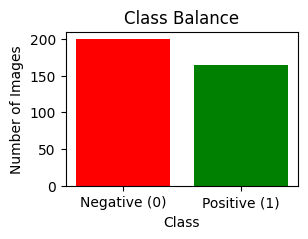

In [11]:
# Assuming y is already defined
unique, counts = np.unique(y, return_counts=True)

# Plot the class balance
plt.figure(figsize=(3, 2))
plt.bar(unique, counts, tick_label=['Negative (0)', 'Positive (1)'], color=['red', 'green'])
plt.title('Class Balance')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

#### Average color distribution

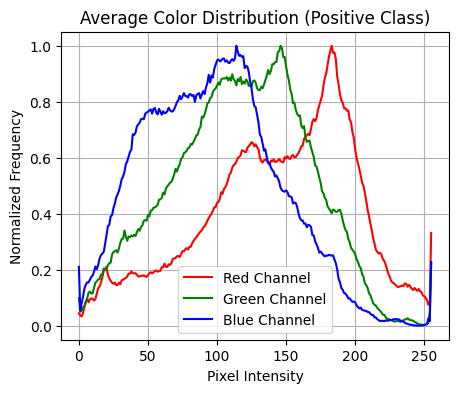

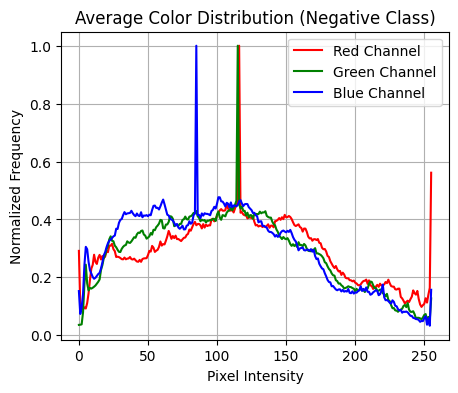

In [12]:
def plot_average_color_distribution(images, num_images=30, title="Average Color Distribution"):
    red_accum = np.zeros(256)
    green_accum = np.zeros(256)
    blue_accum = np.zeros(256)

    images_collected = 0
    all_images = []

    while images_collected < num_images:
        batch = next(images)
        batch = (batch * 255).astype(np.uint8)  # Rescale images to [0, 255]
        for img in batch:
            if images_collected < num_images:
                all_images.append(img)
                images_collected += 1
            else:
                break

    # Compute histograms
    for img in all_images:
        red_accum += np.histogram(img[:, :, 0], bins=256, range=(0, 255))[0]
        green_accum += np.histogram(img[:, :, 1], bins=256, range=(0, 255))[0]
        blue_accum += np.histogram(img[:, :, 2], bins=256, range=(0, 255))[0]

    # Average, normalize, plot
    red_avg = red_accum / num_images
    green_avg = green_accum / num_images
    blue_avg = blue_accum / num_images

    red_avg = red_avg / red_avg.max()
    green_avg = green_avg / green_avg.max()
    blue_avg = blue_avg / blue_avg.max()

    plt.figure(figsize=(5, 4))
    plt.plot(red_avg, color='red', label='Red Channel')
    plt.plot(green_avg, color='green', label='Green Channel')
    plt.plot(blue_avg, color='blue', label='Blue Channel')

    plt.title(title)
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Normalized Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()

# Generator function for batches of images
def image_batch_generator(images, batch_size=32):
    batch_start = 0
    while True:
        batch_end = min(batch_start + batch_size, len(images))
        batch = images[batch_start:batch_end]
        batch_start = batch_end
        yield batch

positive_images, positive_labels = load_images_with_label('Resized', label=1)
negative_images, negative_labels = load_images_with_label('PetImages/Cat', label=0, sample_size=200)

positive_generator = image_batch_generator(positive_images, batch_size=32)
negative_generator = image_batch_generator(negative_images, batch_size=32)

# Plot 
plot_average_color_distribution(positive_generator, num_images=30, title="Average Color Distribution (Positive Class)")
plot_average_color_distribution(negative_generator, num_images=30, title="Average Color Distribution (Negative Class)")


#### Sample images

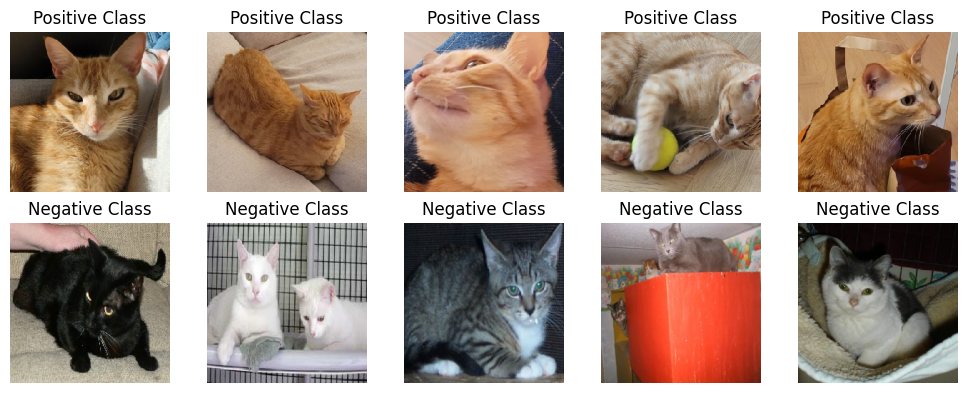

In [13]:
def show_sample_images(positive_images, negative_images, class_names):
    plt.figure(figsize=(10, 4))

    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(positive_images[i])
        plt.title(class_names[1])
        plt.axis('off')

    for i in range(5):
        plt.subplot(2, 5, i + 6)
        plt.imshow(negative_images[i])
        plt.title(class_names[0])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

class_names = ["Negative Class", "Positive Class"]
show_sample_images(positive_images, negative_images, class_names)


#### Check labels

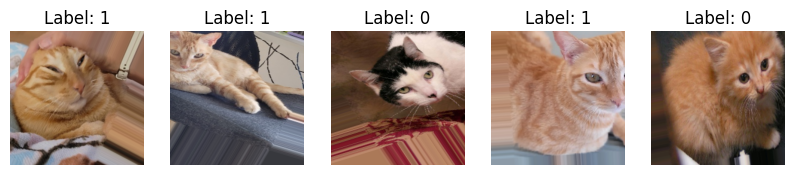

In [14]:
images, labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img_to_show = np.clip(images[i] * 255.0, 0, 255).astype(np.uint8)
    plt.imshow(img_to_show)
    plt.title(f"Label: {int(labels[i])}")
    plt.axis('off')
plt.show()

### EDA Summary
- The images and data were loaded and previewed.
- Classes are well balanced - no further adjustment is needed.
- The average intensities of the color channels in the Piri-Piri pictures and pictures of other cats are visibly different. This is due to his distinct orange color.
- All pictures are loaded in a 224x224 format (since this is the default for EfficientNetB0 and makes it easier to process afterward).

### Data Cleaning
- No further data cleaning is required.

### Plan of Analysis
- No further pre-processing is required.
- In the next section, the model architecture will be developed.
- Different models will then be trained, fit, and evaluated.

## 3. Model Architecture and training

### Transfer learning with EfficientNetB0

#### Freeze weights and train top layer
The approach uses EfficientNetB0 with pre-trained weights as the base model, adding custom layers (global average pooling and a dense layer with sigmoid activation) for binary classification. The model is compiled with the Adam optimizer and binary cross-entropy loss, and trained for 5 epochs using training and validation data generators.

In [15]:
# Load EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Custom layers on top layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')
])

# Compile and summarize
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4310 - loss: 0.6974 - val_accuracy: 0.4521 - val_loss: 0.6947
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.4840 - loss: 0.6942 - val_accuracy: 0.4521 - val_loss: 0.6937
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.5222 - loss: 0.6935 - val_accuracy: 0.5479 - val_loss: 0.6926
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.5094 - loss: 0.6929 - val_accuracy: 0.5479 - val_loss: 0.6925
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.5524 - loss: 0.6923 - val_accuracy: 0.5479 - val_loss: 0.6921


#### Training and validation accuracy: EfficientNetB0 (frozen base layers)

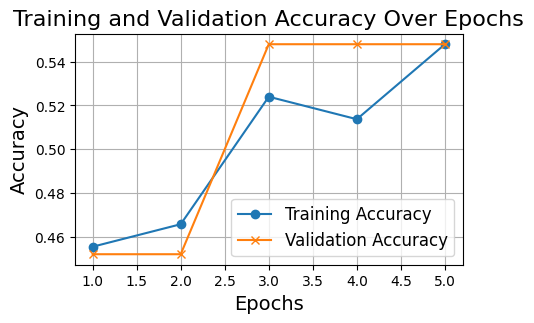

In [16]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot
plt.figure(figsize=(5, 3))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

#### Unfreeze layers for fine-tuning

In [17]:
fine_tune_model = models.clone_model(model)
fine_tune_model.set_weights(model.get_weights())

# Unfreeze all layers
fine_tune_model.layers[0].trainable = True

# Recompile
fine_tune_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_history = fine_tune_model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 0.4790 - loss: 0.7221 - val_accuracy: 0.5479 - val_loss: 0.6914
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.5163 - loss: 0.6903 - val_accuracy: 0.5479 - val_loss: 0.6909
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.6026 - loss: 0.6587 - val_accuracy: 0.5479 - val_loss: 0.6908
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.7023 - loss: 0.6271 - val_accuracy: 0.5479 - val_loss: 0.6907
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.7802 - loss: 0.6040 - val_accuracy: 0.5479 - val_loss: 0.6908


#### Training and validation accuracy: EfficientNetB0 (fine tuned)
The model is cloned and fine-tuned by unfreezing the base layers of EfficientNetB0. The model is recompiled with a lower learning rate (1e-5) and trained for 5 more epochs.

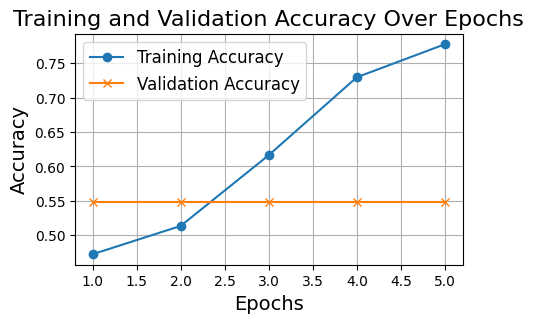

In [18]:
train_accuracy = fine_tune_history.history['accuracy']
val_accuracy = fine_tune_history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot
plt.figure(figsize=(5, 3))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

### Custom CNN

A custom CNN model is built with 3 convolutional layers, max-pooling layers, and dropout to prevent overfitting. It is compiled with the Adam optimizer and binary cross-entropy loss. The model is trained for up to 20 epochs with early stopping to monitor validation loss and restore the best weights.

Model Architecture Summary:


| Layer                | Output Shape     | Parameters    |
|----------------------|------------------|---------------|
| Conv2D (32 filters)  | (224, 224, 32)   | 896           |
| MaxPooling2D         | (112, 112, 32)   | 0             |
| Conv2D (64 filters)  | (112, 112, 64)   | 18,496        |
| MaxPooling2D         | (56, 56, 64)     | 0             |
| Conv2D (128 filters) | (56, 56, 128)    | 73,856        |
| MaxPooling2D         | (28, 28, 128)    | 0             |
| Flatten              | (100352)         | 0             |
| Dense (128 units)    | (128)            | 11,075,712    |
| Dropout (0.5)        | (128)            | 0             |
| Dense (1 unit)       | (1)              | 129           |

- **Optimizer**: Adam (learning rate = 1e-4)
- **Loss function**: Binary crossentropy
- **Metrics**: Accuracy

In [19]:
model_custom = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

model_custom.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Compile and summarize
model_custom.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history_custom = model_custom.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 462ms/step - accuracy: 0.5984 - loss: 0.6740 - val_accuracy: 0.8630 - val_loss: 0.5230
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.7618 - loss: 0.5354 - val_accuracy: 0.9041 - val_loss: 0.3883
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.7556 - loss: 0.5061 - val_accuracy: 0.9315 - val_loss: 0.3140
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.8370 - loss: 0.4082 - val_accuracy: 0.9315 - val_loss: 0.2827
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.8824 - loss: 0.4321 - val_accuracy: 0.9178 - val_loss: 0.2664
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.8651 - loss: 0.3666 - val_accuracy: 0.9041 - val_loss: 0.2571
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.8602 - loss: 0.3509 - val_accuracy: 0.8904 - val_loss: 0.2778
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8816 - loss: 0.2942 - val_accuracy: 0.8767 -

#### Training and validation accuracy: custom (small model)

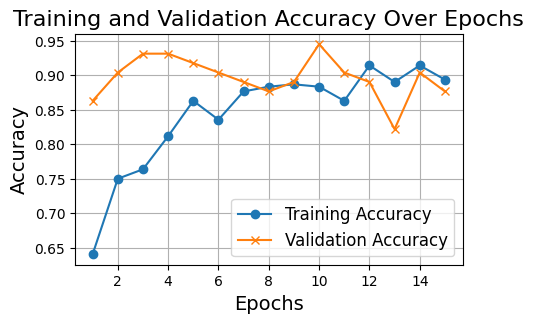

In [20]:
train_accuracy = history_custom.history['accuracy']
val_accuracy = history_custom.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot
plt.figure(figsize=(5, 3))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

## 4. Testing

### Results: Model performance and samples

The model's performance is evaluated using multiple metrics, including accuracy, F1 score, precision, and recall, providing a comprehensive assessment of its effectiveness. A confusion matrix is used to visualize the results.

#### Model performance

In [21]:
# Paths
test_other_cats_dir = "test-cats/test-other-cats"
test_piri_piri_dir = "test-cats/test-piri-piri"

# Load and combine
x_test_other_cats, y_test_other_cats = load_images_with_label(test_other_cats_dir, label=0)  # Negative class
x_test_piri_piri, y_test_piri_piri = load_images_with_label(test_piri_piri_dir, label=1)    # Positive class

x_test = np.vstack((x_test_other_cats, x_test_piri_piri))
y_test = np.hstack((y_test_other_cats, y_test_piri_piri))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Accuracy: 0.9000
F1 Score: 0.9091
Precision: 0.8824
Recall: 0.9375


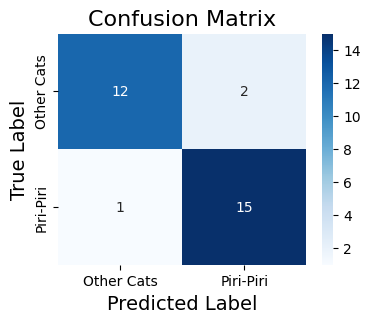

In [22]:
# Make predictions
y_pred_probs = model_custom.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plot
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Other Cats", "Piri-Piri"], yticklabels=["Other Cats", "Piri-Piri"])
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()



#### Samples for visual inspection

In [23]:
def prepare_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0 
    return np.expand_dims(img_array, axis=0)

def predict_cat(image_path, model):
    img = prepare_image(image_path)

    prediction = model.predict(img)

    prediction_value = round(prediction[0][0] * 100, 2)

    result = ''
    if prediction[0][0] > 0.5:
        result = f"It's Piri-Piri! ({prediction_value}%)"
    else:
        result = f"Not Piri-Piri ({prediction_value}%)"

    # Plot
    img_original = load_img(image_path)
    plt.figure(figsize=(2, 2))
    plt.imshow(img_original)
    plt.title(result)
    plt.axis('off')
    plt.show()

    return print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


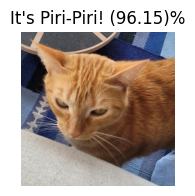

It's Piri-Piri! (96.15)%
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


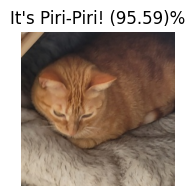

It's Piri-Piri! (95.59)%
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


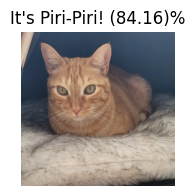

It's Piri-Piri! (84.16)%
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


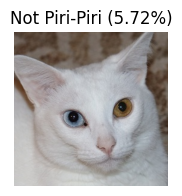

Not Piri-Piri (5.72%)
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


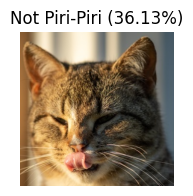

Not Piri-Piri (36.13%)
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


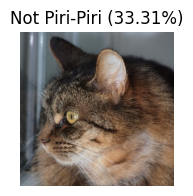

Not Piri-Piri (33.31%)
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


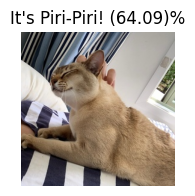

It's Piri-Piri! (64.09)%
None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


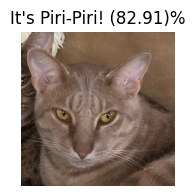

It's Piri-Piri! (82.91)%
None


In [24]:
# Visual inspection

# Correct
print(predict_cat("test-cats/test-piri-piri/other-1.jpg", model_custom))
print(predict_cat("test-cats/test-piri-piri/other-10.jpg", model_custom))
print(predict_cat("test-cats/test-piri-piri/other-13.jpg", model_custom))

# Correct
print(predict_cat("test-cats/test-other-cats/other-4.jpg", model_custom))
print(predict_cat("test-cats/test-other-cats/other-10.jpg", model_custom))
print(predict_cat("test-cats/test-other-cats/other-11.jpg", model_custom))

# Wrong
print(predict_cat("test-cats/test-other-cats/other-3.jpg", model_custom))
print(predict_cat("test-cats/test-other-cats/other-12.jpg", model_custom))

## 5. Conclusion

In this project, three CNN models were trained to detect Piri-Piri: EfficientNetB0 (with both frozen and unfrozen weights) and a custom CNN. The training and validation accuracy plots indicate that EfficientNetB0 overfit the data, likely due to the limited number of images. In contrast, the custom CNN performed very well with the following results:

| Metric        | Value  |
|---------------|--------|
| Accuracy      | 0.9000 |
| F1 Score      | 0.9091 |
| Precision     | 0.8824 |
| Recall        | 0.9375 |

Visual inspection of the results showed that misclassified images were often of cats with similar features to Piri-Piri, especially in shape. To improve performance further, the model could be adjusted to better leverage Piri-Piri's distinct orange color.


## 6. References

[1] Wikipedia contributors. (n.d.). *Convolutional neural network*. Wikipedia. https://en.wikipedia.org/wiki/Convolutional_neural_network.

[2] Chollet, F. (2015). *Keras*. GitHub repository. https://github.com/keras-team/keras.

[3] Abadi, M., Barham, P., Chen, J., Chen, Z., Davis, A., Dean, J., ... & Zheng, X. (2016). *TensorFlow: A system for large-scale machine learning*. In 12th USENIX Symposium on Operating Systems Design and Implementation (OSDI 16), 265-283. https://www.usenix.org/conference/osdi16/technical-sessions/presentation/abadi.

[4] Tan, M., & Le, Q. V. (2019). *EfficientNet: Rethinking model scaling for convolutional neural networks*. In Proceedings of the 36th International Conference on Machine Learning (ICML 2019), 97, 6105-6114. https://proceedings.mlr.press/v97/tan19a.html.

**AI attribution: This work was supported by GitHub Copilot and Open AI ChatGPT, AI-powered code completion tools, which assisted in generating code snippets and providing suggestions during the development process.**